# **Data_understanding**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# For saving models
import joblib
import os

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

Matplotlib is building the font cache; this may take a moment.


In [2]:
shopper_spectrum = pd.read_csv('G:/Data_Science/Project_3-Shopper_Spectrum_Segementation_and_recommendation/Notebook/online_retail.csv')
shopper_spectrum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
shopper_spectrum.shape

(541909, 8)

In [4]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
shopper_spectrum.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
shopper_spectrum.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
shopper_spectrum.duplicated().sum()

np.int64(5268)

# **Data_preprocessing**

In [8]:
# Unique values for categorical columns
categorical_cols = shopper_spectrum.select_dtypes(include=['object']).columns
print(f"\nCategorical Columns Unique Values:")
for col in categorical_cols:
    print(f"{col}: {shopper_spectrum[col].unique()}")


Categorical Columns Unique Values:
InvoiceNo: ['536365' '536366' '536367' ... '581585' '581586' '581587']
StockCode: ['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
Description: ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
InvoiceDate: ['2022-12-01 08:26:00' '2022-12-01 08:28:00' '2022-12-01 08:34:00' ...
 '2023-12-09 12:31:00' '2023-12-09 12:49:00' '2023-12-09 12:50:00']
Country: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [9]:
"""Data preprocessing according to project requirements"""
print("=== DATA PREPROCESSING ===")
initial_shape = shopper_spectrum.shape
print(f"Initial dataset shape: {initial_shape}")

=== DATA PREPROCESSING ===
Initial dataset shape: (541909, 8)


In [10]:
# Remove rows with missing CustomerID
shopper_spectrum = shopper_spectrum.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerID: {shopper_spectrum.shape}")

After removing missing CustomerID: (406829, 8)


In [11]:
# Exclude cancelled invoices (InvoiceNo starting with 'C')
shopper_spectrum = shopper_spectrum[~shopper_spectrum['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancelled invoices: {shopper_spectrum.shape}")

After removing cancelled invoices: (397924, 8)


In [12]:
# Remove negative or zero quantities and prices
shopper_spectrum = shopper_spectrum[(shopper_spectrum['Quantity'] > 0) & (shopper_spectrum['UnitPrice'] > 0)]
print(f"After removing negative/zero quantities and prices: {shopper_spectrum.shape}")

After removing negative/zero quantities and prices: (397884, 8)


In [13]:
# Convert InvoiceDate to datetime
shopper_spectrum['InvoiceDate'] = pd.to_datetime(shopper_spectrum['InvoiceDate'])

In [14]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [15]:
# Create TotalAmount column
shopper_spectrum['TotalAmount'] = shopper_spectrum['Quantity'] * shopper_spectrum['UnitPrice']

In [16]:
shopper_spectrum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
# Convert CustomerID to int
shopper_spectrum['CustomerID'] = shopper_spectrum['CustomerID'].astype(int)

In [18]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


In [19]:
# Drop exact duplicates
before = len(shopper_spectrum)
shopper_spectrum = shopper_spectrum.drop_duplicates()
print('Dropped duplicates:', before - len(shopper_spectrum))

Dropped duplicates: 5192


In [20]:
print(f"Data preprocessing completed!")
print(f"Final dataset shape: {shopper_spectrum.shape}")

Data preprocessing completed!
Final dataset shape: (392692, 9)


In [22]:
# Save a cleaned version
shopper_spectrum.to_csv('data_preprocessed.csv', index=False)

# **=== EXPLORATORY DATA ANALYSIS ===**

In [23]:
"""Exploratory Data Analysis"""
print("=== EXPLORATORY DATA ANALYSIS ===")

=== EXPLORATORY DATA ANALYSIS ===


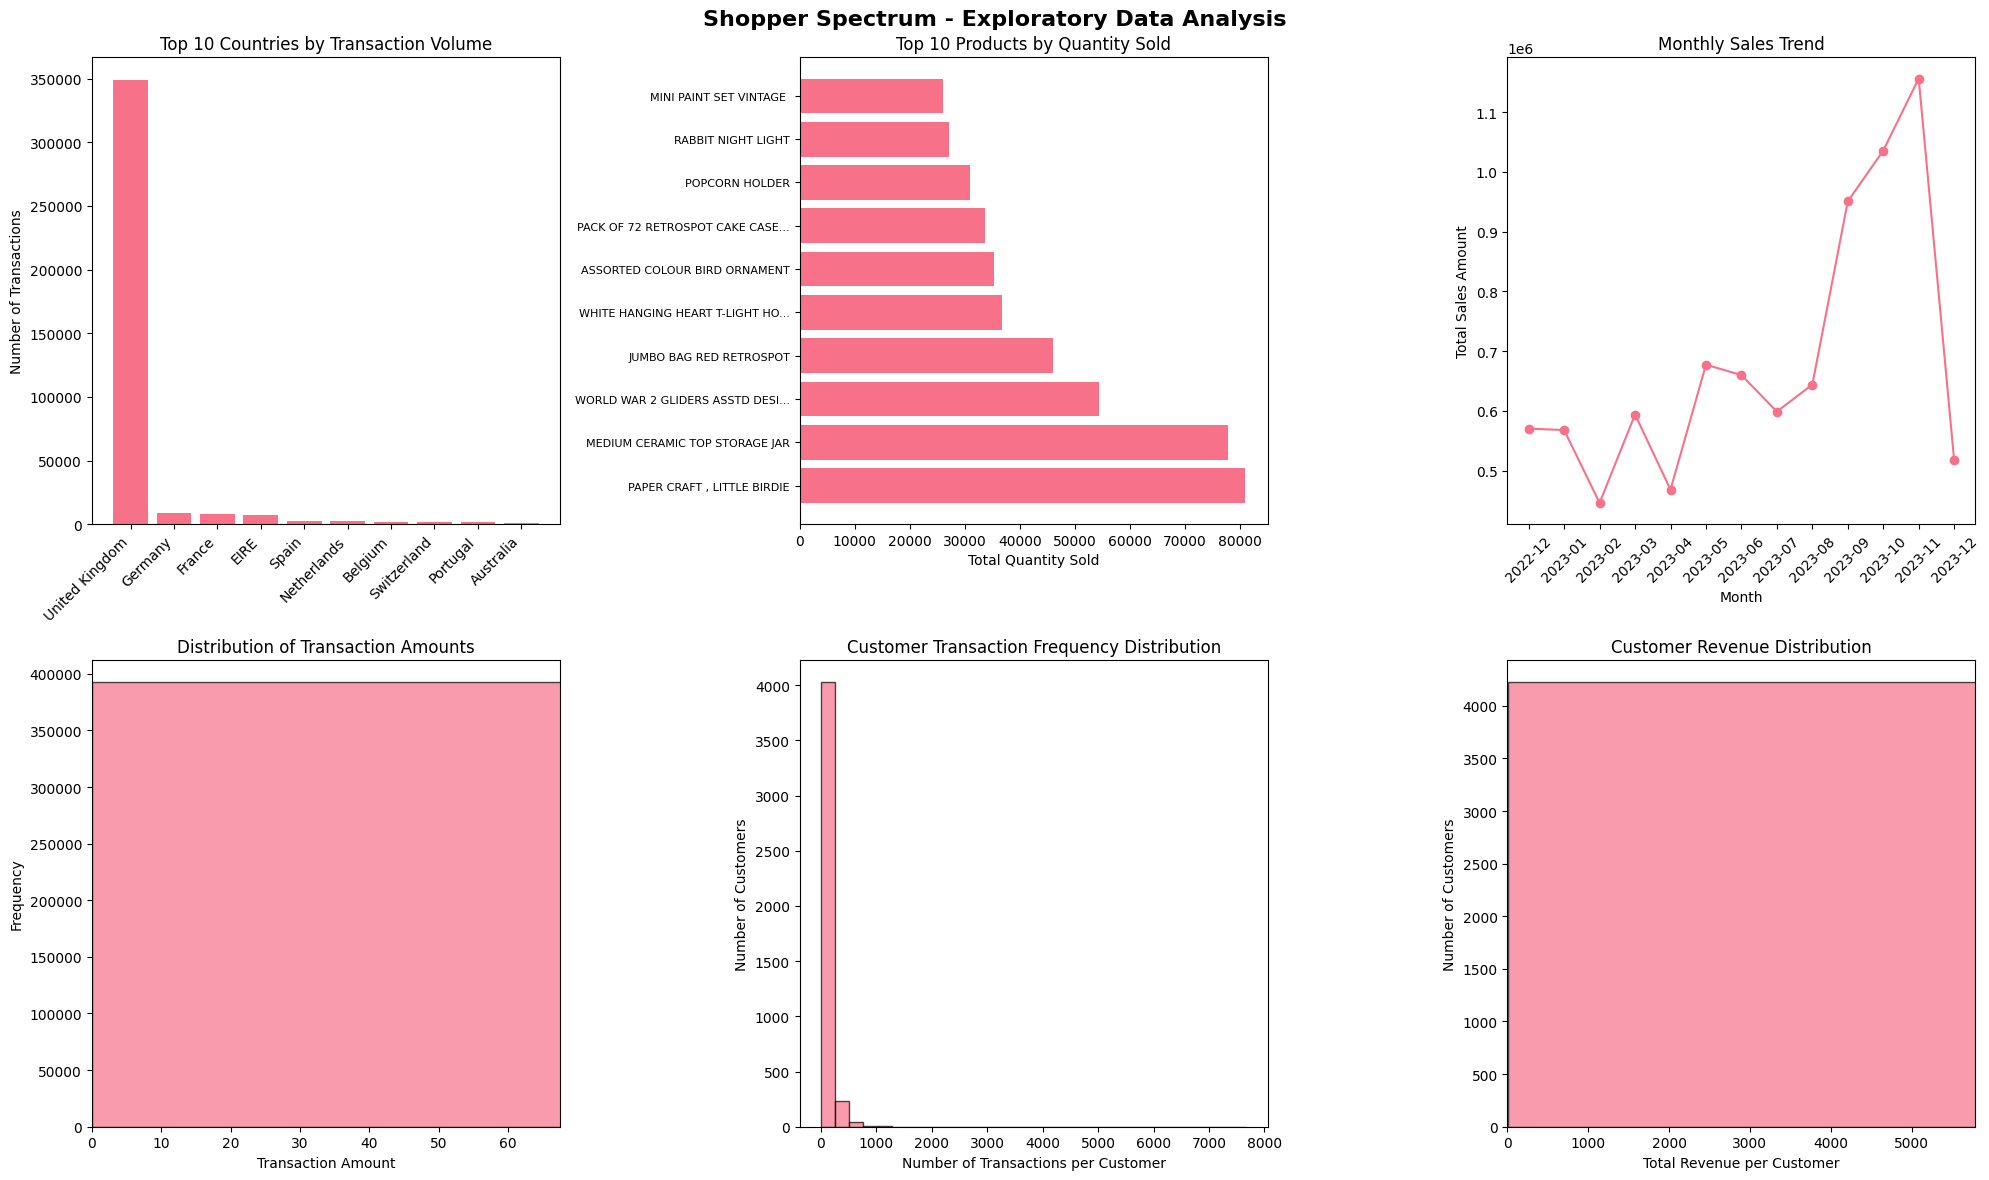

In [24]:
# Set up the plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Shopper Spectrum - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Transaction volume by country
country_counts = shopper_spectrum['Country'].value_counts().head(10)
axes[0, 0].bar(range(len(country_counts)), country_counts.values)
axes[0, 0].set_title('Top 10 Countries by Transaction Volume')
axes[0, 0].set_xticks(range(len(country_counts)))
axes[0, 0].set_xticklabels(country_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Transactions')

# 2. Top-selling products
top_products = shopper_spectrum.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_products)), top_products.values)
axes[0, 1].set_title('Top 10 Products by Quantity Sold')
axes[0, 1].set_yticks(range(len(top_products)))
axes[0, 1].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc 
                           for desc in top_products.index], fontsize=8)
axes[0, 1].set_xlabel('Total Quantity Sold')

# 3. Purchase trends over time
monthly_sales = shopper_spectrum.groupby(shopper_spectrum['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum()
axes[0, 2].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o')
axes[0, 2].set_title('Monthly Sales Trend')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Total Sales Amount')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Monetary distribution per transaction
axes[1, 0].hist(shopper_spectrum['TotalAmount'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Transaction Amounts')
axes[1, 0].set_xlabel('Transaction Amount')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, shopper_spectrum['TotalAmount'].quantile(0.95))

# 5. Customer transaction frequency
customer_freq = shopper_spectrum.groupby('CustomerID').size()
axes[1, 1].hist(customer_freq, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Customer Transaction Frequency Distribution')
axes[1, 1].set_xlabel('Number of Transactions per Customer')
axes[1, 1].set_ylabel('Number of Customers')

# 6. Revenue by customer
customer_revenue = shopper_spectrum.groupby('CustomerID')['TotalAmount'].sum()
axes[1, 2].hist(customer_revenue, bins=30, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Customer Revenue Distribution')
axes[1, 2].set_xlabel('Total Revenue per Customer')
axes[1, 2].set_ylabel('Number of Customers')
axes[1, 2].set_xlim(0, customer_revenue.quantile(0.95))

plt.tight_layout()
plt.show()

In [26]:
shopper_spectrum.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalAmount'],
      dtype='object')

In [27]:
# Top 10 products by revenue
prod_rev = shopper_spectrum.groupby(['StockCode','Description'], dropna=False)['TotalAmount'].sum().sort_values(ascending=False).head(10).reset_index()
print(prod_rev)

  StockCode                         Description  TotalAmount
0     23843         PAPER CRAFT , LITTLE BIRDIE    168469.60
1     22423            REGENCY CAKESTAND 3 TIER    142264.75
2    85123A  WHITE HANGING HEART T-LIGHT HOLDER    100392.10
3    85099B             JUMBO BAG RED RETROSPOT     85040.54
4     23166      MEDIUM CERAMIC TOP STORAGE JAR     81416.73
5      POST                             POSTAGE     77803.96
6     47566                       PARTY BUNTING     68785.23
7     84879       ASSORTED COLOUR BIRD ORNAMENT     56413.03
8         M                              Manual     53419.93
9     23084                  RABBIT NIGHT LIGHT     51251.24


In [28]:
# Top countries by revenue
country_rev = shopper_spectrum.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)
print(country_rev)

Country
United Kingdom    7285024.644
Netherlands        285446.340
EIRE               265262.460
Germany            228678.400
France             208934.310
Australia          138453.810
Spain               61558.560
Switzerland         56443.950
Belgium             41196.340
Sweden              38367.830
Name: TotalAmount, dtype: float64


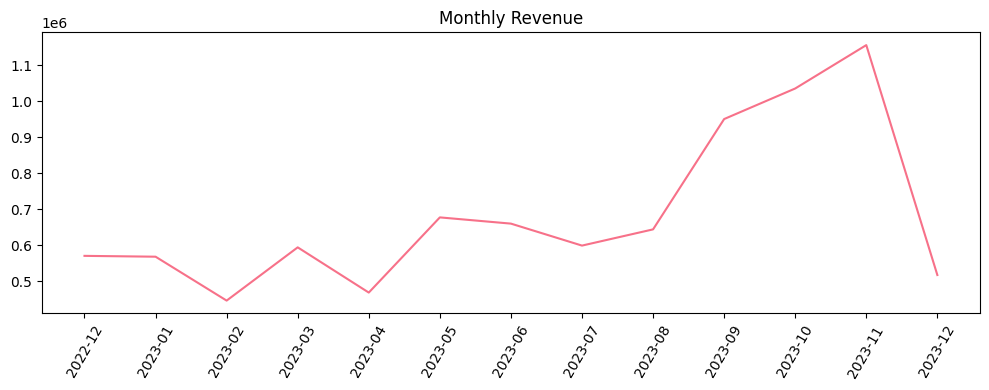

In [30]:
# Monthly revenue trend
shopper_spectrum['InvoiceMonth'] = shopper_spectrum['InvoiceDate'].dt.to_period('M').astype(str)
month_rev = shopper_spectrum.groupby('InvoiceMonth')['TotalAmount'].sum().reset_index()


plt.figure(figsize=(10,4))
plt.plot(month_rev['InvoiceMonth'], month_rev['TotalAmount'])
plt.xticks(rotation=60)
plt.title('Monthly Revenue')
plt.tight_layout()
plt.savefig('figures_monthly_revenue.png', dpi=120)

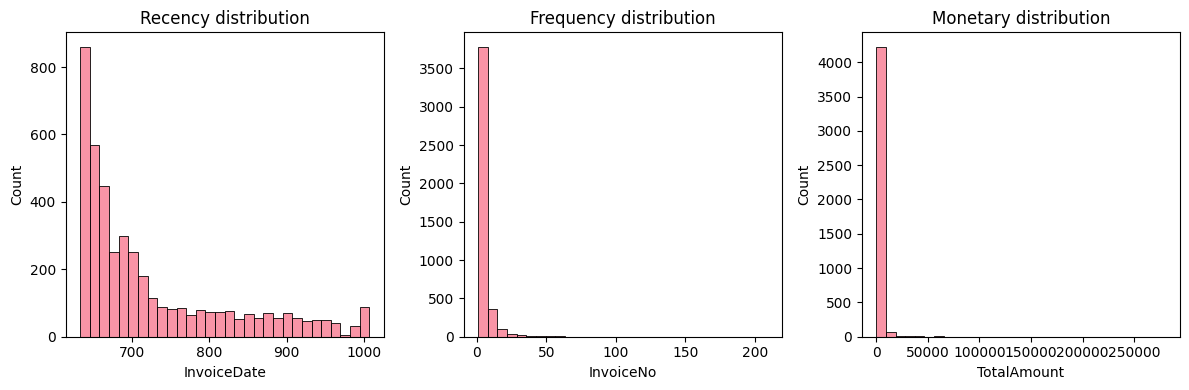

In [31]:
# RFM distributions (histograms)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot((datetime.now() - shopper_spectrum.groupby('CustomerID')['InvoiceDate'].max()).dt.days, bins=30)
plt.title('Recency distribution')
plt.subplot(1,3,2)
sns.histplot(shopper_spectrum.groupby('CustomerID')['InvoiceNo'].nunique(), bins=30)
plt.title('Frequency distribution')
plt.subplot(1,3,3)
sns.histplot(shopper_spectrum.groupby('CustomerID')['TotalAmount'].sum(), bins=30)
plt.title('Monetary distribution')
plt.tight_layout()
plt.savefig('figures_rfm_distributions.png', dpi=120)
plt.show()

In [29]:
# Print summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Total number of customers: {shopper_spectrum['CustomerID'].nunique()}")
print(f"Total number of products: {shopper_spectrum['StockCode'].nunique()}")
print(f"Total number of transactions: {shopper_spectrum['InvoiceNo'].nunique()}")
print(f"Date range: {shopper_spectrum['InvoiceDate'].min()} to {shopper_spectrum['InvoiceDate'].max()}")
print(f"Total revenue: ${shopper_spectrum['TotalAmount'].sum():,.2f}")


=== SUMMARY STATISTICS ===
Total number of customers: 4338
Total number of products: 3665
Total number of transactions: 18532
Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00
Total revenue: $8,911,407.90


# **Recency, Frequency and Monetary(RFM) Analysis**

In [35]:
# Step 5: RFM Analysis and Feature Engineering
print("\n=== RFM ANALYSIS ===")


=== RFM ANALYSIS ===


In [36]:
# Calculate latest date in dataset
latest_date = shopper_spectrum['InvoiceDate'].max()
print(f"Latest date in dataset: {latest_date}")

Latest date in dataset: 2023-12-09 12:50:00


In [37]:
# Group by CustomerID to calculate RFM metrics
rfm_data = shopper_spectrum.groupby('CustomerID').agg({
    'InvoiceDate': 'max',  # Last purchase date
    'InvoiceNo': 'nunique',  # Frequency (number of transactions)
    'TotalAmount': 'sum'  # Monetary (total amount spent)
}).reset_index()

In [38]:
# Calculate Recency (days since last purchase)
rfm_data['Recency'] = (latest_date - rfm_data['InvoiceDate']).dt.days
rfm_data['Frequency'] = rfm_data['InvoiceNo']
rfm_data['Monetary'] = rfm_data['TotalAmount']

In [39]:
# Keep only RFM columns
rfm_final = rfm_data[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

print("RFM Data Sample:")
print(rfm_final.head())
print("\nRFM Statistics:")
print(rfm_final.describe())

RFM Data Sample:
   CustomerID  Recency  Frequency  Monetary
0       12346      325          1  77183.60
1       12347        1          7   4310.00
2       12348       74          4   1797.24
3       12349       18          1   1757.55
4       12350      309          1    334.40

RFM Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     306.482500
50%    15299.500000    50.000000     2.000000     668.570000
75%    16778.750000   141.000000     5.000000    1660.597500
max    18287.000000   373.000000   209.000000  280206.020000


In [56]:
# 5) RFM calculation - method 2

analysis_date = shopper_spectrum['InvoiceDate'].max()
rfm_recency = shopper_spectrum.groupby('CustomerID')['InvoiceDate'].max().to_frame('LastPurchase')
rfm_recency['Recency'] = (analysis_date - rfm_recency['LastPurchase']).dt.days
rfm_freq = shopper_spectrum.groupby('CustomerID')['InvoiceNo'].nunique().to_frame('Frequency')
rfm_monetary = shopper_spectrum.groupby('CustomerID')['TotalAmount'].sum().to_frame('Monetary')
rfm = rfm_recency[['Recency']].join(rfm_freq).join(rfm_monetary)
rfm = rfm.replace([np.inf, -np.inf], np.nan).dropna()
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,1,7,4310.00
12348,74,4,1797.24
12349,18,1,1757.55
12350,309,1,334.40


In [34]:
# Save RFM
rfm.to_csv('artifacts_rfm.csv')

## Visualize RFM distributions

Text(0.5, 0, 'Days since last purchase')

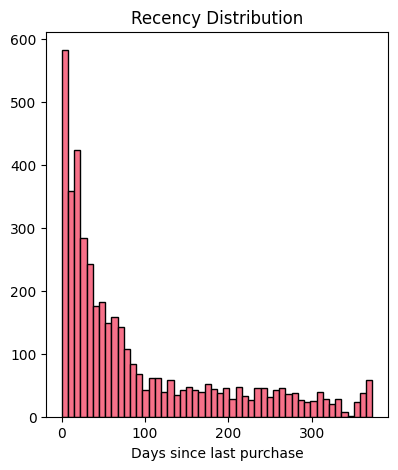

In [41]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(rfm_final['Recency'], bins=50, edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')

Text(0.5, 0, 'Number of transactions')

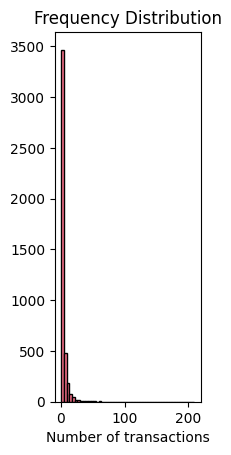

In [42]:
plt.subplot(1, 3, 2)
plt.hist(rfm_final['Frequency'], bins=50, edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Number of transactions')

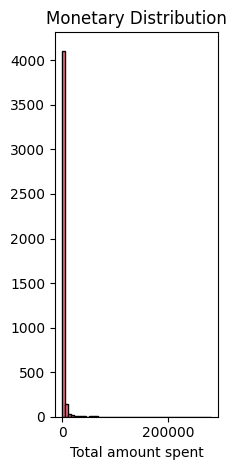

In [43]:
plt.subplot(1, 3, 3)
plt.hist(rfm_final['Monetary'], bins=50, edgecolor='black')
plt.title('Monetary Distribution')
plt.xlabel('Total amount spent')
plt.tight_layout()
plt.show()

# **Scale RFM, choose K (silhouette), train KMeans, evaluate**

In [44]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = None
best_sil = -1
silhouette_results = []

for k in range(2, 9):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_tmp = kmeans_tmp.fit_predict(rfm_scaled)
    sil = silhouette_score(rfm_scaled, labels_tmp)
    
    silhouette_results.append((k, sil, kmeans_tmp.inertia_))
    
    if sil > best_sil:
        best_sil = sil
        best_k = k

print(f"Best k: {best_k} with silhouette score: {best_sil:.4f}")


Best k: 5 with silhouette score: 0.6165


In [51]:
best_k = None
best_sil = -1
silhouette_results = []
for k in range(2,9):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_tmp = kmeans_tmp.fit_predict(rfm_scaled)
    sil = silhouette_score(rfm_scaled, labels_tmp)
    silhouette_results.append((k, sil, kmeans_tmp.inertia_))
    if sil > best_sil:
        best_sil = sil
        best_k = k

In [52]:
print('Silhouette results (k, score, inertia):')
for row in silhouette_results:
    print(row)
print('Best k:', best_k, 'best silhouette:', best_sil)

Silhouette results (k, score, inertia):
(2, 0.5604013068318398, 9356.670424411004)
(3, 0.5853238625904468, 5501.487299697772)
(4, 0.6162275299061803, 4096.3002106622425)
(5, 0.6165002474679847, 3119.7898598001466)
(6, 0.5982885618366588, 2473.793363564766)
(7, 0.5170880799084383, 2023.6444551556126)
(8, 0.49121068260754397, 1798.8600823031466)
Best k: 5 best silhouette: 0.6165002474679847


In [60]:
# Train final model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [55]:
# Save model, scaler
joblib.dump(scaler, 'artifacts_rfm_scaler.pkl')
joblib.dump(kmeans, 'artifacts_rfm_kmeans.pkl')

['artifacts_rfm_kmeans.pkl']

# **Label clusters and visualize**

In [57]:
# Create cluster profile and label heuristically
r_q25, r_q50, r_q75 = rfm['Recency'].quantile([0.25,0.5,0.75])
f_q25, f_q50, f_q75 = rfm['Frequency'].quantile([0.25,0.5,0.75])
m_q25, m_q50, m_q75 = rfm['Monetary'].quantile([0.25,0.5,0.75])

In [61]:
print(rfm.columns)

Index(['Recency', 'Frequency', 'Monetary', 'Cluster'], dtype='object')


In [62]:
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().reset_index()
cluster_label_map = {}
for _, row in cluster_profile.iterrows():
    c = int(row['Cluster'])
    cR, cF, cM = row['Recency'], row['Frequency'], row['Monetary']
    label = 'Occasional'
    if (cR <= r_q25) and (cF >= f_q75) and (cM >= m_q75):
        label = 'High-Value'
    elif (cR >= r_q75) and (cF <= f_q25) and (cM <= m_q25):
        label = 'At-Risk'
    elif (cF >= f_q50) and (cM >= m_q50):
        label = 'Regular'
    else:
        label = 'Occasional'
    cluster_label_map[c] = label

rfm['Segment'] = rfm['Cluster'].map(cluster_label_map)
rfm.to_csv('artifacts_rfm_with_segments.csv')
print('Cluster profile:')
print(cluster_profile)
print('Cluster labels:', cluster_label_map)

Cluster profile:
   Cluster     Recency   Frequency       Monetary
0        0   42.918635    3.650262    1333.132908
1        1  247.469426    1.553151     478.648242
2        2    5.500000  120.500000   55099.491250
3        3   14.671362   21.286385   12813.941596
4        4    6.666667   42.833333  190808.536667
Cluster labels: {0: 'Regular', 1: 'Occasional', 2: 'High-Value', 3: 'High-Value', 4: 'High-Value'}


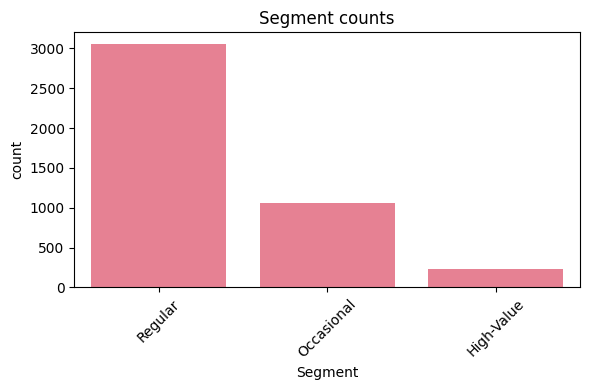

In [63]:
# Visualize cluster counts
plt.figure(figsize=(6,4))
sns.countplot(x='Segment', data=rfm, order=list(cluster_label_map.values()))
plt.title('Segment counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures_segment_counts.png', dpi=120)
plt.show()

## **8) Item-based collaborative filtering (product similarity)**